In [13]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.2.0


'/device:GPU:0'

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import pprint
import lightgbm as lgb
#from feature_selector import FeatureSelector
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline
pd.set_option('display.max_rows', 500)
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

In [15]:
wednesday = pd.read_csv('./archive/Wednesday-workingHours.csv',low_memory = False)
#friday = friday.rename(str.lstrip, axis='columns')
wednesday = wednesday.rename(str.lstrip, axis='columns')

In [16]:
df = wednesday
#df = df.sample(n = 200000)
print(df['Label'].unique())
print(df.shape)
df = df.dropna()
print(df.shape)

['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']
(692703, 79)
(691695, 79)


In [17]:
#defining important features in the set| not included in feature selection.
imp = ['Destination Port', 'Flow Duration', 'Total Fwd Packets','Total Backward Packets']

In [18]:
#for performing feature selection
X = df.loc[:,df.columns != "Label"]
#removing first four features considered very important
X = X.drop(imp,axis = 1)
y = df.loc[:,df.columns == "Label"]
print(X.shape)


(691695, 74)


Label
BENIGN              439972
DoS GoldenEye        10293
DoS Hulk            230124
DoS Slowhttptest      5499
DoS slowloris         5796
Heartbleed              11
dtype: int64


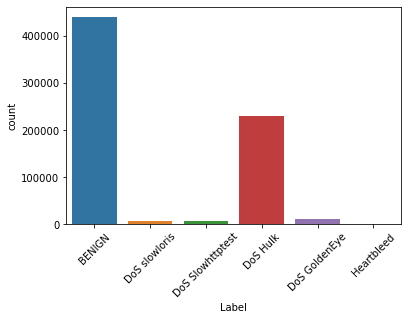

In [19]:
#class distribution <- classifying feature
def ClassDistribution(y):
    ax = sns.countplot(y['Label'],label="Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    print(y.groupby('Label').size())

ClassDistribution(y)
#B, M = y.value_counts()
#print('Number of Benign: ',B)
#print('Number of Malignant : ',M)

In [20]:
#remove columns with more than 75% missing values
def RemoveMissing(train):
    train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
    train_missing.head()
    train_missing = train_missing.index[train_missing > 0.75]
    all_missing = list(set(train_missing))
    train.drop(all_missing,axis = 1)
    print('There are %d columns with more than 75%% missing values' % len(all_missing))
    return train

X = RemoveMissing(X)

There are 0 columns with more than 75% missing values


In [21]:
#remove columns with only 1 unique value
def remove_single_unique_values(dataframe):
    cols_to_drop = dataframe.nunique()
    cols_to_drop = cols_to_drop.loc[cols_to_drop.values==1].index
    print('There are %d columns with only 1 unique value' % len(cols_to_drop))
    dataframe = dataframe.drop(cols_to_drop,axis=1)
    return dataframe

X = remove_single_unique_values(X)
print(X.shape)

There are 10 columns with only 1 unique value
(691695, 64)


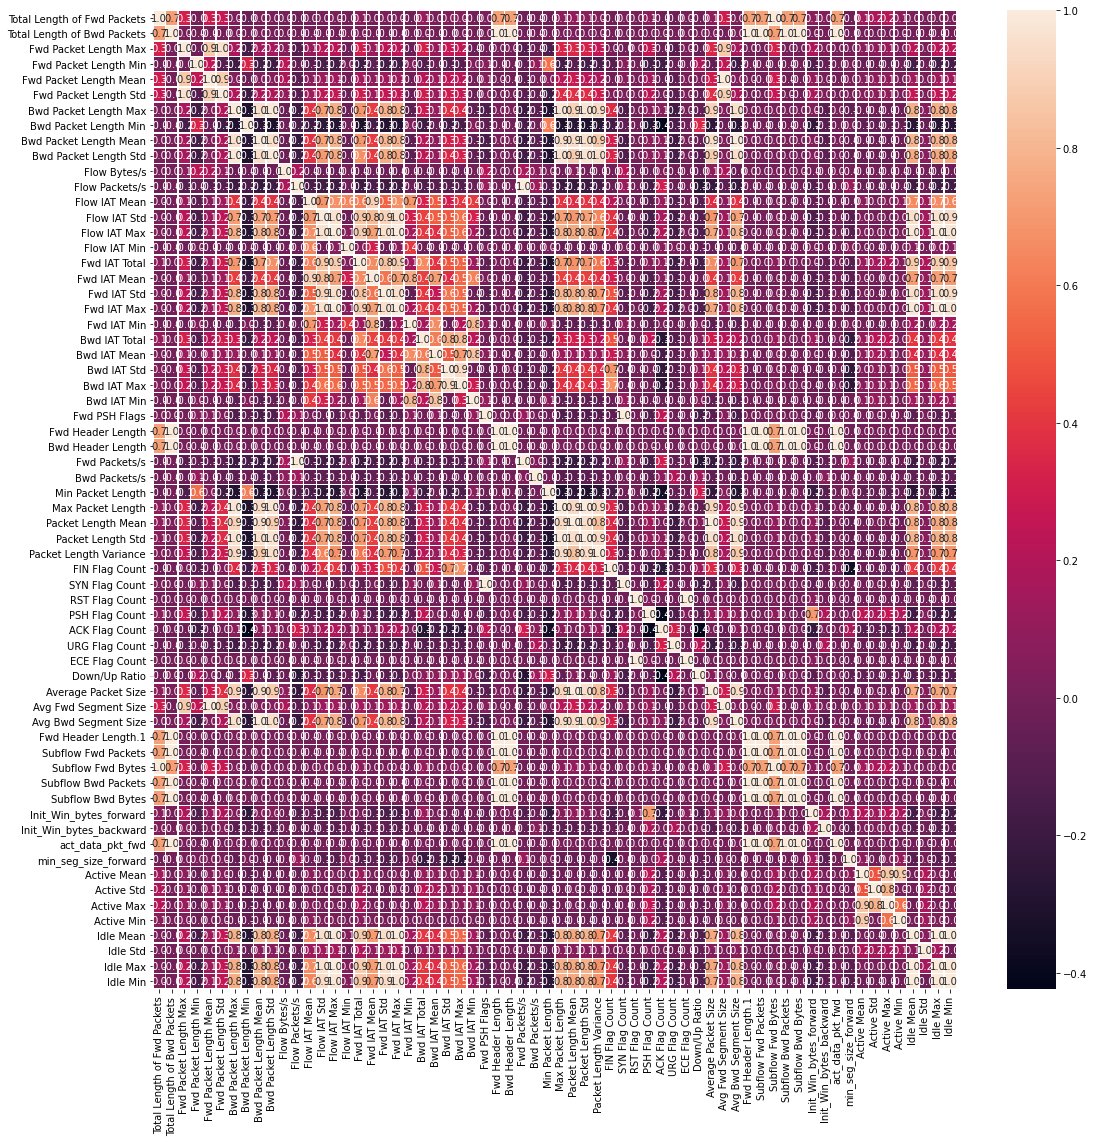

In [22]:
#heatmap
f,ax = plt.subplots(figsize=(18, 18))
corr = X.corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [23]:
columns = np.full((corr.shape[0],), True, dtype=bool)
to_drop = []
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] > 0.8:
            if columns[j]:
                columns[j] = False
                to_drop.append((corr.columns)[j])
print(to_drop)
X = X.drop(to_drop,axis = 1)
print(X.shape)

['Subflow Fwd Bytes', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'act_data_pkt_fwd', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Avg Fwd Segment Size', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Average Packet Size', 'Avg Bwd Segment Size', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Idle Mean', 'Idle Max', 'Idle Min', 'Bwd IAT Min', 'Bwd IAT Max', 'SYN Flag Count', 'ECE Flag Count', 'Active Max', 'Active Min']
(691695, 30)


In [24]:
#add back the important features removed earlier
for i in imp:
    X[i] = df[i]

print(X.shape)
print(X.columns)
#encoding and scaling stuff.
categorical = []
for x in X.columns:
    if X[x].dtype == 'object':
        categorical.append(x)
#encoding and scaling

encoder = LabelEncoder()
for a in categorical:
    X[a] = encoder.fit_transform(X[a])

# feature scaling
scaler = RobustScaler()
X = scaler.fit_transform(X)
y = encoder.fit_transform(y.values)

(691695, 34)
Index(['Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Fwd PSH Flags', 'Bwd Packets/s', 'Min Packet Length', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Active Mean', 'Active Std', 'Idle Std',
       'Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets'],
      dtype='object')


ValueError: Input contains infinity or a value too large for dtype('float64').

Label
BENIGN              439972
DoS GoldenEye        10293
DoS Hulk            230124
DoS Slowhttptest      5499
DoS slowloris         5796
Heartbleed              11
dtype: int64


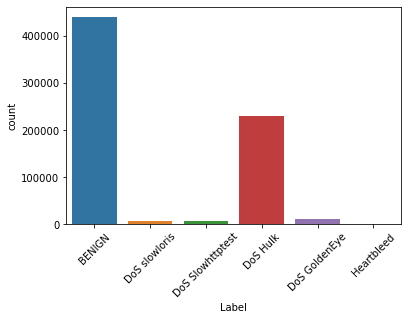